# Recommendation Notebook 


## Notes

### 2/25
- Added graph analysis for recommendations
- Organized charts appropriately

### 1/12
- Tweaked hyperparameters to get optimal performance (for now)
- Blank descriptions are now replaced with club name respectively
- Clubs that aren't confirmed are not included in dataset

### 1/10
- Create 3rd temporary recommendation system based off of favorites and interest lists. Basically just added case where favorites_list does not exist, so then tags are taken into consideration instead. This version still does not take tags into account when a favorites list does exist, however. We can improve this part if we want in future versions.

### 1/8
- Added .env variable support for use with version control
- Added frequency distribution graph for words from descriptions

### 1/6
- Created 2nd temporary recommendation system based off of favorites, would like to include tags incorporated, even though we use the recommendation function that takes into consideration tags already
- Figure out how to recommend even with no favorites, just tags

### 12/31
- Added various graphs for visualizing performance of model
- Fixed environment by list dependencies without specific versions
- Re-added directly importing data from MongoDB

### 12/30
- Will most likely want to give slack for k when recommending, since we don't want to have the exact same results each time
- (Possibly pick from distributions?)
- favorite_recommendation does not work as well as hoped, need to reevaluate how well it works + other strategies

### 12/28
- Switched from euclidean distance to cosine similarity
- Fixed runtime for vectorizing the table

### 12/23
- Annotation, a lot
- Recommend function takes into consideration tags
- Notebook formatted

### 12/10
- Started
- Issues importing from Tejas's environment, unable to connect to DB so exported directly from MongoDB
- Used nlp/gensim to vectorize description, use K-nn approach to recommend

# Imports

In [1]:
# Native imports
import os
import json
import random
from collections import Counter
from pprint import pprint

# MongoDB Python driver import
import pymongo

# 3rd-party data science imports
import pandas as pd
import seaborn as sns
# pd.set_option('display.max_rows', None)

# NLP Pre-processing tools
import re, string, unicodedata
import nltk
#import contractions      # https://github.com/kootenpv/contractions
#import inflect           # https://github.com/jaraco/inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
#import flashtext         # https://github.com/vi3k6i5/flashtext

# Main NLP tool kit
import gensim           # https://radimrehurek.com/gensim/auto_examples/index.html

# Model training
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

from sklearn.manifold import TSNE

import bs4 as bs
import nltk
from nltk.tokenize import sent_tokenize # tokenizes sentences
import re
from nltk.stem import PorterStemmer
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import numpy as np

# Graph network analysis
import networkx as nx

# Fancy progress reporting
from tqdm import tqdm

# Extra tooling
import dotenv

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 12)

In [3]:
# Load .env variables
from dotenv import load_dotenv
load_dotenv()

True

## Step 0: Fetch data

### Directly from MongoDB

In [4]:
conn_string = os.getenv('MONGO_URI_PROD')
client = pymongo.MongoClient(conn_string)

In [5]:
ALL_CLUB_TAGS = []

# Fetch list of tags
for tag in client['production-db']['tag'].find():
    ALL_CLUB_TAGS += [{
        'id': tag['_id'],
        'name': tag['name']
    }]

all_club_tags_df = pd.DataFrame(ALL_CLUB_TAGS)
all_club_tags_df.head(25)

,id,name
0,0,Advocacy
1,1,ASUC
2,2,Business
3,3,CalGreek
4,4,Community Service
5,5,Computer Science
6,6,Consulting
7,7,Cultural
8,8,Design
9,9,Engineering


In [6]:
LIST_CLUB_INFO = []

CLUB_SEARCH_PARAMS = {
    'role': 'officer',
    'confirmed': True,
    'club.reactivated': True
}

for user in client['production-db']['new_base_user'].find(CLUB_SEARCH_PARAMS):
    club_name = user['club']['name'].strip()
    club_link_name = user['club']['link_name'].strip()
    club_description = user['club']['about_us'].strip()
    club_tags = user['club']['tags']
    
    LIST_CLUB_INFO += [{
        'name': club_name,
        'link_name': club_link_name,
        'description': club_description,
        'tags': club_tags,
    }]
    
club_db_df = pd.DataFrame(LIST_CLUB_INFO)
club_db_df = club_db_df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
club_db_df = club_db_df.reset_index(drop = True)

for (i, row) in club_db_df.iterrows():
    row['description'] = row['description'] if len(row['description']) != 0 else row['name']

club_db_df

,name,link_name,description,tags
0,EthiCAL Apparel,ethical-apparel,<p>EthiCAL Apparel is a <strong>student-run so...,"[2, 8, 20]"
1,UC Rally Committee,uc-rally-committee,The UC Rally Committee’s members are the offic...,"[20, 21]"
2,Codebase,codebase,Codebase is a community of developers that emp...,"[5, 19, 22]"
3,Berkeley Phi Beta Lambda,berkeley-phi-beta-lambda,Berkeley Phi Beta Lambda (PBL) is a chapter of...,"[2, 6, 15]"
4,BEAM- Berkeley Engineers and Mentors,beam--berkeley-engineers-and-mentors,BEAM- Berkeley Engineers and Mentors,"[4, 18, 20]"
...,...,...,...,...
133,Phi Delta Epsilon,phi-delta-epsilon,<p>Phi Delta Epsilon is UC Berkeley's premier ...,"[11, 15, 19]"
134,Underwater Robotics at Berkeley,underwater-robotics-at-berkeley,"<p>URobotics at Berkeley designs, builds, and ...","[8, 9, 22]"
135,REACH! Asian and Pacific Islander Recruitment ...,reach-asian-and-pacific-islander-recruitment-a...,<p>Come be a part of the community that helps ...,"[0, 7, 14]"
136,UNICEF at Berkeley,unicef-at-berkeley,<p>As one of the leading UNICEF Campus Initiat...,"[0, 19, 20]"


# Club Recommendation

## Step 1: Clean table descriptions

In [7]:
def clean_table(table):
    """
    Description:
    Cleans club dataframe descriptions into another column containing a lists of significant words in each description.
    
    Input:
    table - club dataframe
    
    Output:
    cleaned_table - table with a new column: "cleaned descriptions"
    
    """
    
    def clean_description(description):
        """
        Description:
        Clean single description into lists of significant words.

        Input:
        description - string of club description 

        Output:
        new_description - list of significant words in description
        """
        
        try: 
            # Remove punctuation
            new_description = re.sub("[^a-zA-Z]", " ", description)

            # Tokenize into words (all lower case)
            new_description = new_description.lower().split()

            # Remove stopwords
            eng_stopwords = set(stopwords.words("english"))
            new_description = [w for w in new_description if not w in eng_stopwords]

            # Remove "uc" and "berkeley"
            uc_berkeley = ['uc', 'berkeley', 'also', 'providing', 'various', 'well', 'provide', 'one']
            new_description = [w for w in new_description if not w in uc_berkeley]
        except TypeError:
            return [""]

        return new_description
    
    clean_descriptions = []
    
    for i in np.arange(len(table)):
        clean_descriptions += [clean_description(table['description'][i])]
        
    cleaned_table = table.drop(['description'], axis=1)
    cleaned_table['clean_description'] = clean_descriptions
    
    return cleaned_table

### Execution

In [8]:
cleaned_table = clean_table(club_db_df)
cleaned_table

,name,link_name,tags,clean_description
0,EthiCAL Apparel,ethical-apparel,"[2, 8, 20]","[p, ethical, apparel, strong, student, run, so..."
1,UC Rally Committee,uc-rally-committee,"[20, 21]","[rally, committee, members, official, guardian..."
2,Codebase,codebase,"[5, 19, 22]","[codebase, community, developers, empowers, st..."
3,Berkeley Phi Beta Lambda,berkeley-phi-beta-lambda,"[2, 6, 15]","[phi, beta, lambda, pbl, chapter, largest, stu..."
4,BEAM- Berkeley Engineers and Mentors,beam--berkeley-engineers-and-mentors,"[4, 18, 20]","[beam, engineers, mentors]"
...,...,...,...,...
133,Phi Delta Epsilon,phi-delta-epsilon,"[11, 15, 19]","[p, phi, delta, epsilon, premier, internationa..."
134,Underwater Robotics at Berkeley,underwater-robotics-at-berkeley,"[8, 9, 22]","[p, urobotics, designs, builds, tests, underwa..."
135,REACH! Asian and Pacific Islander Recruitment ...,reach-asian-and-pacific-islander-recruitment-a...,"[0, 7, 14]","[p, come, part, community, helps, educate, emp..."
136,UNICEF at Berkeley,unicef-at-berkeley,"[0, 19, 20]","[p, leading, unicef, campus, initiatives, aspi..."


### Frequency distribution from combined BOWs from cleaned descriptions

In [9]:
BOWs = cleaned_table['clean_description'].tolist()
total_BOW = [word for bow in BOWs for word in bow]

In [10]:
print('Total # of words: ', len(total_BOW))
print('Total # of unique words: ', len(set(total_BOW)))

Total # of words:  6491
Total # of unique words:  2130


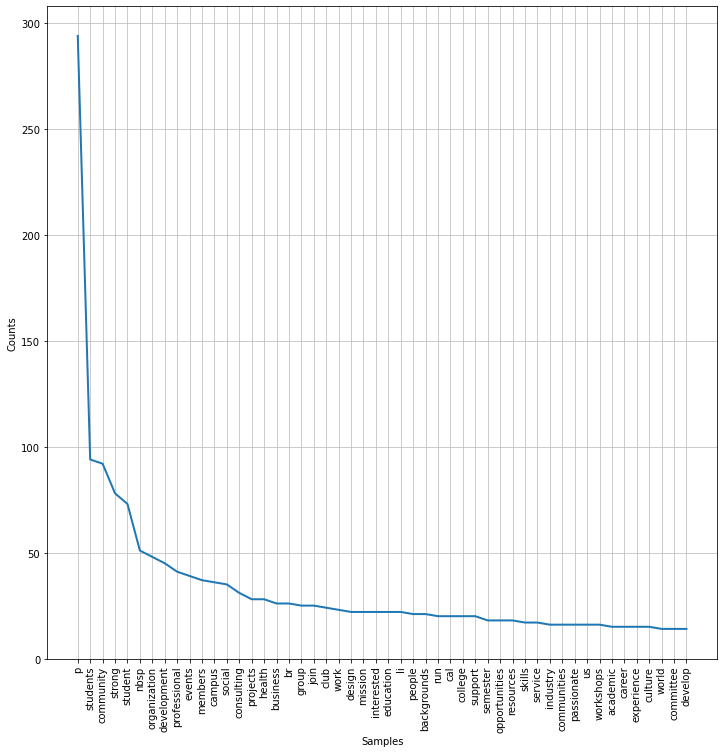

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [11]:
nltk.FreqDist(total_BOW).plot(50, cumulative=False)

## Step 2: Add vectors

In [12]:
def vectorize_table(table, yield_model = False):
    MIN_WORD_COUNT = 20
    VECTOR_SIZE = 100
    CONTEXT_WINDOW_SIZE = 10
    
    """
    Description:
    Uses cleaned table to create another column containing vectors using gensim's word2vec.
    
    Input:
    table - cleaned table
    
    Output:
    vectorized_table - table with a new_column: "vector sum"
    
    Run word2vec model
    """
    
    list_vectors = []
    
    model = gensim.models.Word2Vec(
        table['clean_description'],
        min_count=MIN_WORD_COUNT,
        size=VECTOR_SIZE,
        window=CONTEXT_WINDOW_SIZE,
        compute_loss=True,
        sample=1e-3 / 2,
        seed=42
    )
    
    for i in range(len(table)):
        ith_description = table['clean_description'][i]    
        
        ith_vector_list = []
        for ith_description_word in ith_description:
            if ith_description_word in model.wv:
                ith_vector_list += [model.wv[ith_description_word]]
        
        if len(ith_vector_list) == 0:
            description_sum_vector = [1e-6] * VECTOR_SIZE
        else:
            description_sum_vector = sum(np.array(ith_vector_list))
            
        list_vectors += [description_sum_vector]
        
    vectorized_table = table.copy()
    vectorized_table['vector_sum'] = list_vectors
    
    if yield_model:
        return vectorized_table, model
    else:
        return vectorized_table

### Execution

In [13]:
vector_table, w2v_model = vectorize_table(cleaned_table, yield_model=True)
print('Model Loss:', w2v_model.get_latest_training_loss())
vector_table

Model Loss: 4052.73095703125


,name,link_name,tags,clean_description,vector_sum
0,EthiCAL Apparel,ethical-apparel,"[2, 8, 20]","[p, ethical, apparel, strong, student, run, so...","[0.016750464, 0.06519594, -0.041203227, 0.0320..."
1,UC Rally Committee,uc-rally-committee,"[20, 21]","[rally, committee, members, official, guardian...","[-0.002125038, 0.006268226, -0.012004879, -0.0..."
2,Codebase,codebase,"[5, 19, 22]","[codebase, community, developers, empowers, st...","[0.010858139, 0.009822875, 0.008234135, -0.000..."
3,Berkeley Phi Beta Lambda,berkeley-phi-beta-lambda,"[2, 6, 15]","[phi, beta, lambda, pbl, chapter, largest, stu...","[0.013610686, 0.028650416, -0.017453682, 0.003..."
4,BEAM- Berkeley Engineers and Mentors,beam--berkeley-engineers-and-mentors,"[4, 18, 20]","[beam, engineers, mentors]","[1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-06, 1e-..."
...,...,...,...,...,...
133,Phi Delta Epsilon,phi-delta-epsilon,"[11, 15, 19]","[p, phi, delta, epsilon, premier, internationa...","[0.02431234, 0.041250497, -0.049086403, 0.0143..."
134,Underwater Robotics at Berkeley,underwater-robotics-at-berkeley,"[8, 9, 22]","[p, urobotics, designs, builds, tests, underwa...","[0.028280908, 0.055456597, -0.04993642, 0.0350..."
135,REACH! Asian and Pacific Islander Recruitment ...,reach-asian-and-pacific-islander-recruitment-a...,"[0, 7, 14]","[p, come, part, community, helps, educate, emp...","[0.0006114319, 0.073735215, -0.042405862, 0.01..."
136,UNICEF at Berkeley,unicef-at-berkeley,"[0, 19, 20]","[p, leading, unicef, campus, initiatives, aspi...","[0.010449508, 0.0026950547, -0.020081483, -0.0..."


### TSNE plot from word2vec mode

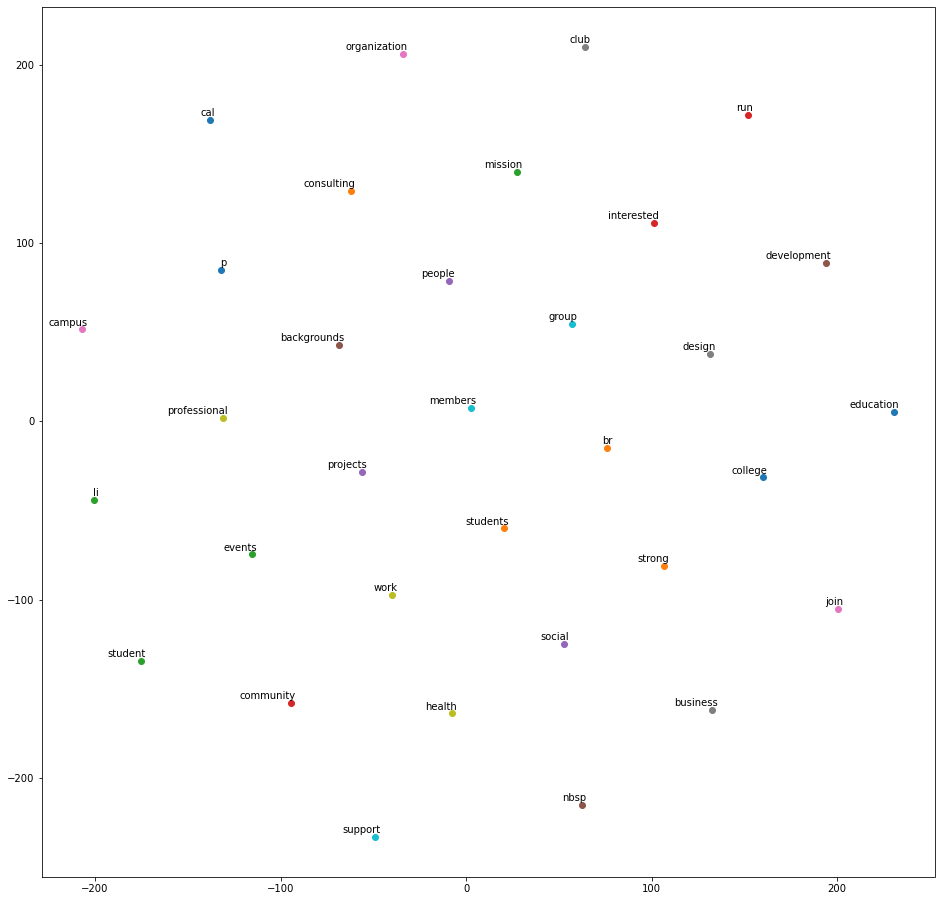

In [14]:
# Source: https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne

PERPLEXITY = 60

def tsne_plot(model, perpl):
    "Creates a TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model.wv[word])
        labels.append(word)
        
    tsne_model = TSNE(perplexity=perpl, n_components=2, init='pca', n_iter=1000, random_state=42)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
    
tsne_plot(w2v_model, PERPLEXITY)

## Step 3: Create distance table

In [15]:
from scipy import spatial

def create_distance_table(table):
    """
    Description:
    Uses a vectorized table to create a pivot table containing distances between each club.
    
    Input:
    table - table with vectorized descriptions
    
    Output:
    distance_table - table containing all distances between each club
    
    """
    
    dict = table[['link_name', 'vector_sum']].set_index('link_name')['vector_sum'].to_dict()
    distance_list = []
    
    for club_1 in dict:
        vector_1 = dict[club_1]
        distance_dictionary = {}
        
        for club_2 in dict:
            vector_2 = dict[club_2]
            
            cosine_sim = 1 - spatial.distance.cosine(vector_1, vector_2)
            distance_dictionary[club_2] = cosine_sim
            
        distance_list += [distance_dictionary]
        
    distance_table = pd.DataFrame(data=distance_list)
    distance_table.index = table['link_name']
    
    return distance_table

### Execution

In [16]:
distance_table = create_distance_table(vector_table)
distance_table

,ethical-apparel,uc-rally-committee,codebase,berkeley-phi-beta-lambda,beam--berkeley-engineers-and-mentors,berkeley-finance-club,eta-kappa-nu,bridgeusa,taiwanese-student-association-,launchpad,...,hong-kong-affairs-association-of-berkeley,uc-berkeley-hksa-hong-kong-student-association,b-side,free-ventures,nextgen-consulting,phi-delta-epsilon,underwater-robotics-at-berkeley,reach-asian-and-pacific-islander-recruitment-and-retention-center,unicef-at-berkeley,volunteers-around-the-world
link_name,,,,,,,,,,,,,,,,,,,,,
ethical-apparel,1.000000,0.371485,0.490059,0.576518,0.076188,0.404078,0.469942,0.413719,0.526559,0.517446,...,0.928196,0.927881,0.942339,0.931149,0.895524,0.899287,0.877266,0.926189,0.675582,0.754030
uc-rally-committee,0.371485,1.000000,0.369556,0.495125,-0.087962,0.320313,0.329731,0.306436,0.535661,0.372942,...,0.352371,0.431273,0.421067,0.395055,0.418824,0.444611,0.376383,0.357094,0.455037,0.441602
codebase,0.490059,0.369556,1.000000,0.763326,0.153445,0.551392,0.499626,0.526035,0.638953,0.676838,...,0.469878,0.561596,0.446965,0.449267,0.636554,0.471404,0.508262,0.451441,0.481391,0.505173
berkeley-phi-beta-lambda,0.576518,0.495125,0.763326,1.000000,0.035016,0.651709,0.550402,0.566254,0.581404,0.645740,...,0.507040,0.641269,0.585158,0.498590,0.718759,0.586445,0.591799,0.494591,0.526730,0.556817
beam--berkeley-engineers-and-mentors,0.076188,-0.087962,0.153445,0.035016,1.000000,0.037307,0.074973,0.136243,0.085180,0.008115,...,0.100842,0.079747,0.081152,0.098955,0.112717,0.057673,0.120174,0.061986,-0.030954,-0.004443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
phi-delta-epsilon,0.899287,0.444611,0.471404,0.586445,0.057673,0.434083,0.428888,0.415374,0.482667,0.490219,...,0.887808,0.895081,0.866593,0.867172,0.850353,1.000000,0.926457,0.852000,0.591761,0.747960
underwater-robotics-at-berkeley,0.877266,0.376383,0.508262,0.591799,0.120174,0.371767,0.354993,0.491278,0.518520,0.388910,...,0.886030,0.839064,0.846496,0.883304,0.866433,0.926457,1.000000,0.844974,0.583073,0.662878
reach-asian-and-pacific-islander-recruitment-and-retention-center,0.926189,0.357094,0.451441,0.494591,0.061986,0.412254,0.339797,0.413749,0.468903,0.461652,...,0.958988,0.822785,0.806576,0.960081,0.826770,0.852000,0.844974,1.000000,0.680469,0.686649


### Heatmap correlation between all clubs

<AxesSubplot:ylabel='link_name'>

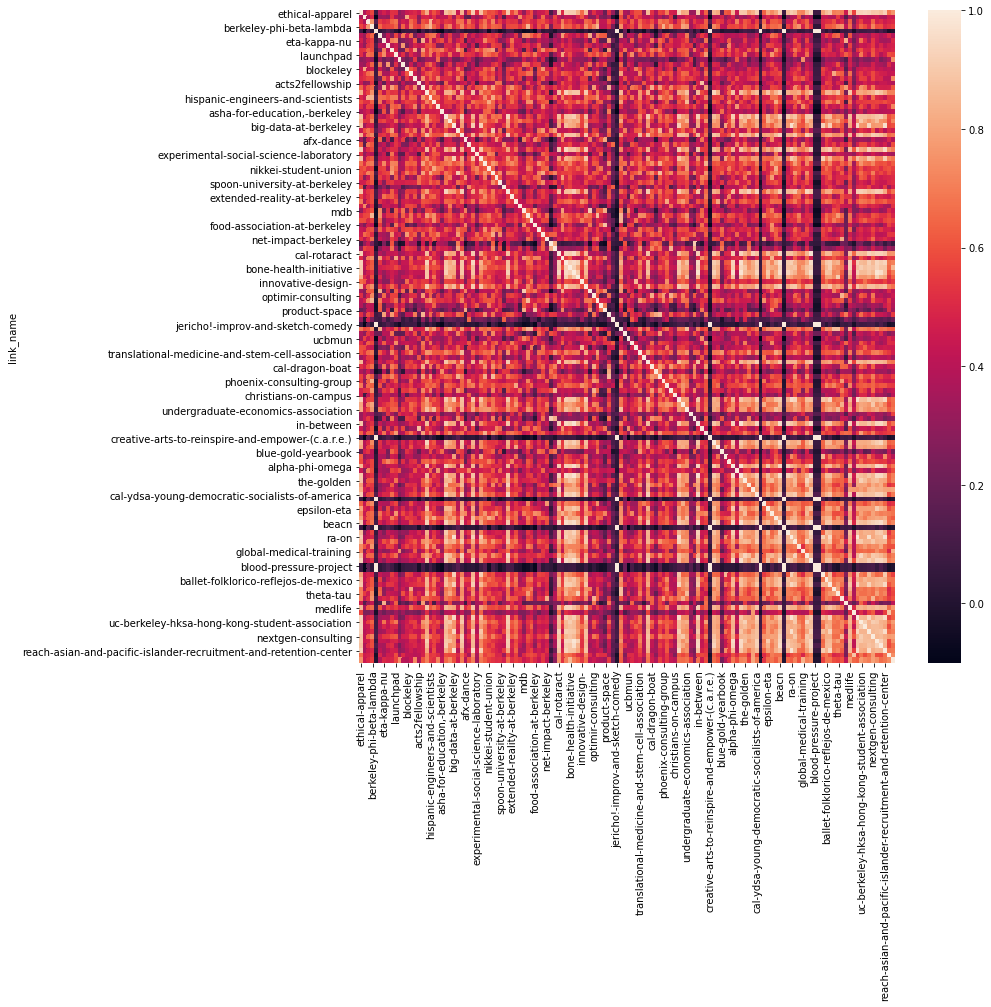

In [17]:
sns.heatmap(distance_table)

### Distance-based distribution plot from all clubs

/home/tejashah88/extra-software/anaconda3/envs/sc-notebook/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

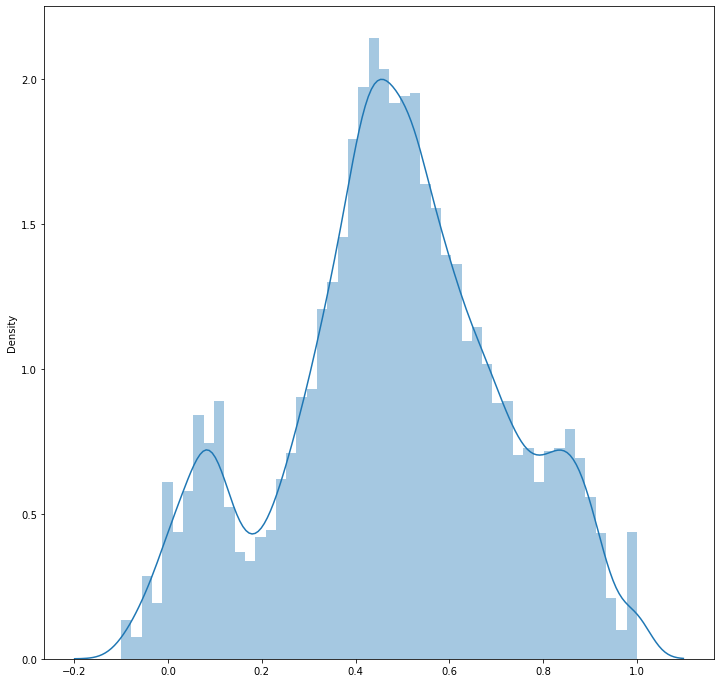

In [18]:
sns.distplot(distance_table)

## Step 4: Recommend

In [19]:
def recommend(table, club_db_df, club_name, k):
    """
    Description:
    Recommends club based off of k-nearest neighbors, prioritizing matching tags.
    
    Input:
    table - table containing all distances between each club
    club_db_df - table containing club tags
    club_name - string of club name we want to create recommendations for
    k - represents how many neighbors
    
    Output:
    recommendations - k recommendations based off of closest distances
    
    """
    
    def filter_by_tag(club_link_name, k):
        """
        Description:
        Return boolean list that contains max amount of matching tags that satisfies matching k amount of clubs.

        Output:
        filtered_clubs - list of booleans based off of clubs filtered by tags

        """
        
        def count_tags(a, b, num_tags):
            """
            Description:
            Returns if club A and B contain at least k tags in common.

            Input:
            a - list of club tags for club A
            b - list of club tags for club B
            num_tags - minimum number of tags required to match

            Output:
            matching_tags - # of matching tags

            """
            matching_tags = len(set(a).intersection(set(b))) >= num_tags
            return matching_tags

        club_tags = club_db_df[club_db_df['link_name'] == club_link_name]['tags'].iloc[0]
        filtered_clubs = []

        num_of_tags = len(club_tags)
        while (np.count_nonzero(filtered_clubs) - 1 < k):
            if num_of_tags == 0:
                print("Matched {} tags".format(num_of_tags))
                return [True] * len(club_db_df)

            filtered_clubs = []
            for other_club_tags in club_db_df['tags']:
                if count_tags(club_tags, other_club_tags, num_of_tags):
                    filtered_clubs += [True]
                else:
                    filtered_clubs += [False]
            num_of_tags -= 1

        else:
            # print("Matched {} tags".format(num_of_tags + 1))
            # print("{} matches".format(np.count_nonzero(filtered_clubs)))
            return filtered_clubs
    
    filtered_clubs = filter_by_tag(club_name, k)
        
    filtered_distances = table[filtered_clubs]
    club_distances = filtered_distances[club_name] 
    sorted_club_distances = club_distances.sort_values(ascending = True, na_position = 'last')
    recommendations = sorted_club_distances.keys()[1: k + 1]
    
    return list(recommendations)

In [20]:
recommendations = recommend(distance_table, club_db_df, 'big-data-at-berkeley', 3)
recommendations

['eta-kappa-nu', 'girls-teaching-girls-to-code-@-berkeley', 'blockeley']

In [21]:
def get_description(club_name):
    return club_db_df[club_db_df['name'] == club_name]['description'].iloc[0]

In [22]:
get_description('Extended Reality at Berkeley')

'Extended Reality @ Berkeley is a registered student organization at Cal for people interested in experiencing or developing virtual and augmented reality technology and applications.'

In [23]:
def recommend_by_club(club_index = -1):
    if club_index == -1:
        club_index = random.randint(0, len(club_db_df))
    print("Club index: {}".format(club_index))
    club_name = club_db_df.iloc[club_index]['link_name']
    recommended = recommend(distance_table, club_db_df, club_name, 3)
    return club_name, recommended

In [24]:
recommend_by_club(46)

Club index: 46


('girls-who-code-at-berkeley',
 ['web-development-berkeley', 'big-data-at-berkeley', 'eta-kappa-nu'])

In [25]:
recommend_by_club()


Club index: 59


('entrepreneurs@berkeley',
 ['underwater-robotics-at-berkeley',
  'ethical-apparel',
  'valley-consulting-group'])

## Visualizing/Evaluating Performance

In [26]:
normed_df = vector_table['vector_sum'].apply(lambda arr: arr / np.linalg.norm(arr))
normed_vector_table = np.array([arr for arr in normed_df.to_numpy()])

In [27]:
means = np.mean(normed_vector_table.T, axis=1)
stds = np.std(normed_vector_table.T, axis=1)

print('Lowest mean:', np.min(means))
print('Highest mean:', np.max(means))

print('Lowest Standard Dev:', np.min(stds))
print('Highest Standard Dev:', np.max(stds))

Lowest mean: -0.1527852897201597
Highest mean: 0.22141794750223995
Lowest Standard Dev: 0.048468887511316124
Highest Standard Dev: 0.09902982487518483


/home/tejashah88/extra-software/anaconda3/envs/sc-notebook/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/tejashah88/extra-software/anaconda3/envs/sc-notebook/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

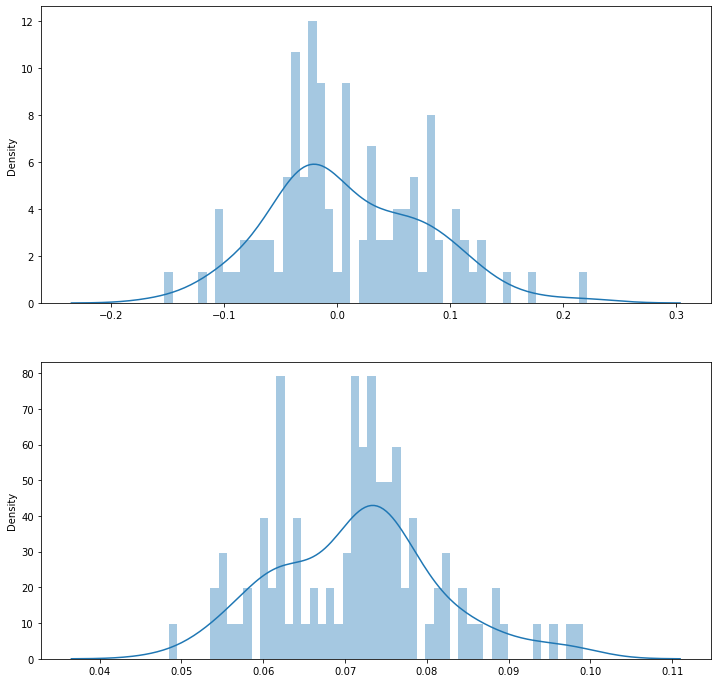

In [28]:
dims = normed_vector_table.shape[1]
fig, axs = plt.subplots(nrows=2)

NUM_BINS = 50

sns.distplot(means, bins=NUM_BINS, ax=axs[0])
sns.distplot(stds, bins=NUM_BINS, ax=axs[1])

## (Beta) Student Profile Recommendation

In [29]:
def favorite_recommendations(favorite_list, interest_list, k):
    """
    Description:
    Returns k amount of recommendations based off of favorite_list and interest_list specific to user.

    Input:
    favorite_list - array that contains names of clubs favorited
    interest_list - array that contains tags (aka interests) student has chosen
    k - integer amount of recommendations

    Output:
    recommendations - array of club names recommended

    """
    #condition that favorite list doesn't exist -- use interest list
    if len(favorite_list) ==0:
        new_club_df = club_db_df[['name', 'tags']]
        intersections = [set.intersection(set(interest_list), set(i)) for i in new_club_df['tags']]
        new_club_df['intersection_with_interests'] = [list(i) for i in intersections]
        new_club_df['num_intersection'] = [len(i) for i in new_club_df['intersection_with_interests']]
        new_club_df = new_club_df.sort_values('num_intersection', ascending = False)
        final_recommendation = list(new_club_df['name'][:k])
        
    else:
        club_list_pool = []
        for club in favorite_list:
            club_list = recommend(distance_table, club_db_df, club, 6)
            for recommended_club in club_list:
                club_list_pool += [recommended_club]
    
        not_in_favorite = [club for club in club_list_pool if club not in favorite_list]

        unique_recommended = list(dict.fromkeys(not_in_favorite))
        sample_len = len(unique_recommended)
        recommended_indices = random.sample(range(1, sample_len), k)
        recommended = [not_in_favorite[recommended_index] for recommended_index in recommended_indices]

        #print(recommended)
        #print(len(recommended))
        final_recommendation = recommended[:k]

    return final_recommendation
        
    
favorite_recommendations([], [2,4,6], 5)

/home/tejashah88/extra-software/anaconda3/envs/sc-notebook/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


['Net Impact Berkeley',
 'Seed Base Consulting',
 'UpSync Consulting',
 'Beta Alpha Psi',
 'Ascend']

## Generic Club Recommender Class

In [30]:
class GenericRecommender:
    def __init__(self, table, list_of_club_tags):
        self.dist_table = table
        self.list_of_club_tags = list_of_club_tags
        
    def _count_tags(self, a, b, num_tags):
        """
        Description:
        Returns if club A and B contain at least k tags in common.

        Input:
        a - list of club tags for club A
        b - list of club tags for club B
        num_tags - minimum number of tags required to match

        Output:
        matching_tags - # of matching tags

        """
        matching_tags = len(set(a).intersection(set(b))) >= num_tags
        return matching_tags
    
    
    def _filter_by_tag(self, club_tags, k):
        """
        Description:
        Return boolean list that contains max amount of matching tags that satisfies matching k amount of clubs.

        Output:
        filtered_clubs - list of booleans based off of clubs filtered by tags

        """

        filtered_clubs = []

        num_of_tags = len(club_tags)
        while (np.count_nonzero(filtered_clubs) - 1 < k):
            if num_of_tags == 0:
                print(f'Matched {num_of_tags} tags')
                return [True] * len(self.list_of_club_tags)

            filtered_clubs = []
            for other_club_tags in self.list_of_club_tags:
                if self._count_tags(club_tags, other_club_tags, num_of_tags):
                    filtered_clubs += [True]
                else:
                    filtered_clubs += [False]
            num_of_tags -= 1

        else:
            #print("Matched {} tags".format(num_of_tags + 1))
            #print("{} matches".format(np.count_nonzero(filtered_clubs)))
            return filtered_clubs
        
    def recommend(self, club_link_name, k):
        """
        Description:
        Recommends club based off of k-nearest neighbors, prioritizing matching tags.

        Input:
        table - table containing all distances between each club
        club_db_df - table containing club tags
        club_name - string of club name we want to create recommendations for
        k - represents how many neighbors

        Output:
        recommendations - k recommendations based off of closest distances

        """
        # First, fetch required data
        try:
            club_info = client['production-db']['new_base_user'].find({
                'role': 'officer',
                'club.link_name': club_link_name
            })[0]['club']
        except IndexError:
            return None
        
        target_club_link_name = club_info['link_name']
        target_club_tags = club_info['tags']
        
        # Next, filter by tags
        filtered_clubs = self._filter_by_tag(target_club_tags, k)
        
        # Finally, sort by distances as pre-calculated from Word2Vec
        filtered_distances = self.dist_table[filtered_clubs]
        club_distances = filtered_distances[target_club_link_name]
        sorted_club_distances = club_distances.sort_values(ascending = True, na_position = 'last')
        recommendations = sorted_club_distances.keys()[1: k + 1]

        return list(recommendations)
        

In [31]:
LIST_OF_TAGS = [club['tags'] for club in LIST_CLUB_INFO]
g_recommender = GenericRecommender(distance_table, LIST_OF_TAGS)

In [32]:
RANDOM_CLUB = True
SPECIFIC_CLUB = 'big-data-at-berkeley'

if not RANDOM_CLUB:
    target_club = [club for club in LIST_CLUB_INFO if club['link_name'] == SPECIFIC_CLUB][0]
else:
    target_club = random.choice(LIST_CLUB_INFO)

print(f'Club name: "{target_club["name"]}"')
print(f'Club link name: "{target_club["link_name"]}"')

recommendations = g_recommender.recommend(target_club['link_name'], 3)

print('Club recommendations:')
for club_name in recommendations:
    print(f'  "{club_name}"' + ('' if club_name != target_club['link_name'] else ' (SELF)'))
    

Club name: "Berkeley ANova"
Club link name: "berkeley-anova"
Club recommendations:
  "engineers-without-borders"
  "creative-arts-to-reinspire-and-empower-(c.a.r.e.)"
  "blood-pressure-project"


## Graph network recommendation analysis

In [33]:
# Define needed variables and helper functions
NUM_RECOMMENDED_CLUBS = 3
LIST_OF_CLUB_LINK_NAMES = [club['link_name'] for club in LIST_CLUB_INFO if club]

def random_club():
    return random.choice(LIST_OF_CLUB_LINK_NAMES)

def sorted_dict(d):
    return dict(sorted(d.items()))

In [34]:
# Construct graph of recommendations
r_graph = nx.DiGraph()

# Add nodes
r_graph.add_nodes_from(LIST_OF_CLUB_LINK_NAMES)

# Add edges
for club_link_name in tqdm(LIST_OF_CLUB_LINK_NAMES):
    recommendations = g_recommender.recommend(club_link_name, 3)
    
    for recommendation in recommendations:
        r_graph.add_edge(club_link_name, recommendation)

nx.freeze(r_graph)

100%|██████████| 138/138 [00:06<00:00, 20.30it/s]


In [35]:
# Look at basic atributes of graph itself
print('Number of nodes:\t', r_graph.number_of_nodes())
print('Number of edges:\t', r_graph.number_of_edges()) # Should be number of nodes * 3

Number of nodes:	 138
Number of edges:	 414


In [36]:
print('Number of self loops:', nx.number_of_selfloops(r_graph)) # Should ideally be 0
pprint([edge[0] for edge in nx.selfloop_edges(r_graph)])

Number of self loops: 9
['codebase',
 'launchpad',
 'blockeley',
 'afx-dance',
 'the-berkeley-forum',
 'innovative-design-',
 'translational-medicine-and-stem-cell-association',
 'codeology',
 'greening-the-greeks']


In [37]:
chosen_club_name = random_club()
print(f'Chosen club name: "{chosen_club_name}"\n')

in_connecting_clubs = [two_pair[0] for two_pair in r_graph.in_edges(chosen_club_name)]
pprint(in_connecting_clubs)

Chosen club name: "blockeley"

['blockeley',
 'big-data-at-berkeley',
 'girls-teaching-girls-to-code-@-berkeley',
 'game-design-and-development-@-berkeley',
 'web-development-berkeley']


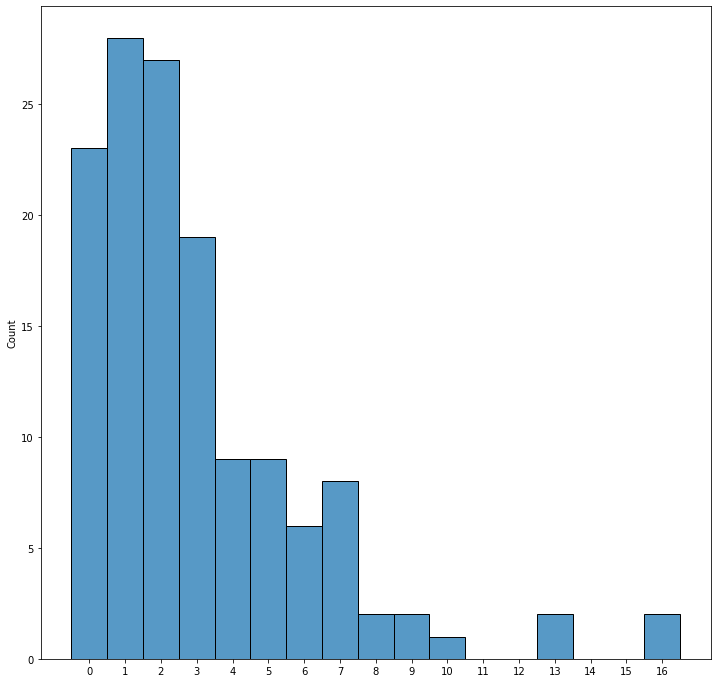

In [38]:
# In-degree centrality: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.in_degree_centrality.html
n_minus_1 = r_graph.number_of_nodes() - 1
all_in_degs = [round(in_deg_frac * n_minus_1) for in_deg_frac in nx.in_degree_centrality(r_graph).values()]

# histplot docs: https://seaborn.pydata.org/generated/seaborn.histplot.html
sns.histplot(all_in_degs, stat="count", discrete=True, bins=1)

# Force x-axis to show integer values for labels
plt.xticks(range(max(all_in_degs) + 1))
plt.show()

In [39]:
from collections import Counter
sorted_dict(Counter(all_in_degs))

{0: 23,
 1: 28,
 2: 27,
 3: 19,
 4: 9,
 5: 9,
 6: 6,
 7: 8,
 8: 2,
 9: 2,
 10: 1,
 13: 2,
 16: 2}